ICESat-2 orientation can be: backward, forward, and transition. During transition, ICESat-2 is maneuvering between the two orientations. Science quality is potentially degraded while in transition mode. (Source: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL03_data_dict_v005.pdf)


The parameter "/orbit_info/sc_orient" in ATL03 denotes the orientation of ICESat-2.

0 = backward

1 = forward

2 = transition

In [ ]:
import h5py
import pandas as pd

Script reads the variable "/orbit_info/sc_orient" to determine orientation.

In [49]:
def subsetBeamsv2(f, strength):
    '''Subsets either strong or weak beams in ATL03 from a h5py dataset'''
    orientation = f['orbit_info']['sc_orient'][0] ## Extract the orientation
    if strength == 'strong':
        if orientation == 0:
            strong_left = pd.DataFrame(data={'lat': f['gt1l/land_segments/latitude'][:],
                                            'lon': f['gt1l/land_segments/longitude'][:],
                                            'ch': f['gt1l/land_segments/canopy/h_canopy'][:]})
            
            strong_central = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                            'lon': f['gt2l/land_segments/longitude'][:],
                                            'ch': f['gt2l/land_segments/canopy/h_canopy'][:]})
            
            strong_right = pd.DataFrame(data={'lat': f['gt3l/land_segments/latitude'][:],
                                            'lon': f['gt3l/land_segments/longitude'][:],
                                            'ch': f['gt3l/land_segments/canopy/h_canopy'][:]})
            
        elif orientation == 1:
            strong_left = pd.DataFrame(data={'lat': f['gt1r/land_segments/latitude'][:],
                                            'lon': f['gt1r/land_segments/longitude'][:],
                                            'ch': f['gt1r/land_segments/canopy/h_canopy'][:]})
            
            strong_central = pd.DataFrame(data={'lat': f['gt2r/land_segments/latitude'][:],
                                            'lon': f['gt2r/land_segments/longitude'][:],
                                            'ch': f['gt2r/land_segments/canopy/h_canopy'][:]})
            
            strong_right = pd.DataFrame(data={'lat': f['gt3r/land_segments/latitude'][:],
                                            'lon': f['gt3r/land_segments/longitude'][:],
                                            'ch': f['gt3r/land_segments/canopy/h_canopy'][:]})
            
        else:
            print('Error: invalid strength input')
            
        return strong_left, strong_central, strong_right

In [50]:
# Read the ATL08 file, and extract the strong beam data
f = h5py.File('insert_filename_here', 'r')

strong_left,strong_central,strong_right = subsetBeamsv2(f, 'strong')

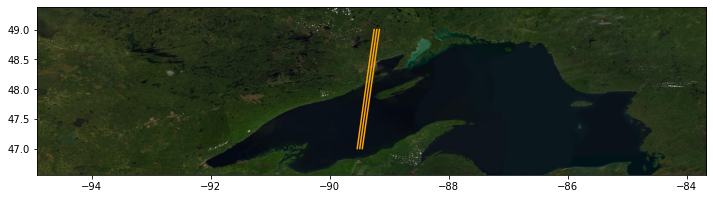

In [64]:
# Subset the data to the Michigan UP
strong_left = strong_left[(strong_left['lat']>47) & (strong_left['lat'].values<49)]
strong_central = strong_central[(strong_central['lat']>47) & (strong_central['lat']<49)]
strong_right = strong_right[(strong_right['lat']>47) & (strong_right['lat']<49)]


# Plot a map of the region
import contextily as cx

west,south,east,north = (strong_left['lon'].min()-5,
                         strong_central['lat'].min(),
                         strong_right['lon'].max()+5,
                        strong_central['lat'].max())

img,shp = cx.bounds2img(west,
                  south,
                  east,
                  north,
                  ll=True,
                  source=cx.providers.Esri.WorldImagery)
img,shp = cx.warp_tiles(img,shp, 'epsg:4326')

f, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(img, extent=shp) # Map overlay
ax.plot(strong_left['lon'], strong_left['lat'], color='orange')
ax.plot(strong_central['lon'], strong_central['lat'], color='orange')
ax.plot(strong_right['lon'], strong_right['lat'], color='orange')

In [ ]:
# Plot only high confidence (i.e. likely signal) photons only
fig,axs = plt.subplots(1,3)
axs[0].plot(strong_left['lat'][strong_left['ch']<1e38], strong_left['ch'][strong_left['ch']<1e38], '.', markersize=1)
axs[0].set_title('Left strong beam')
axs[1].plot(strong_central['lat'][strong_central['ch']<1e38], strong_central['ch'][strong_central['ch']<1e38], '.', markersize=1)
axs[1].set_title('Central strong beam')
axs[2].plot(strong_right['lat'][strong_right['ch']<1e38], strong_right['ch'][strong_right['ch']<1e38], '.', markersize=1)
axs[2].set_title('Right strong beam')

for ax in axs.flat:
    ax.label_outer()
plt.tight_layout()
plt.show()